# Basic classification: Classify images of clothing

Classification is the process of predicting the class of given data points. Classes are sometimes called as targets/ labels or categories. Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y).

For example, spam detection in email service providers can be identified as a classification problem. This is s binary classification since there are only 2 classes as spam and not spam. A classifier utilizes some training data to understand how given input variables relate to the class. In this case, known spam and non-spam emails have to be used as the training data. When the classifier is trained accurately, it can be used to detect an unknown email.

Classification belongs to the category of supervised learning where the targets also provided with the input data. There are many applications in classification in many domains such as in credit approval, medical diagnosis, target marketing etc.

Reference: https://www.tensorflow.org/tutorials/keras/classification

Reference: https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623

### *Note*

Ensure you have all required libraries, that's why they're listed below.

Example used TensorFlow '2.1.0'


In [1]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
import tensorflow as tf
from tensorflow import keras

import glob
import imageio
import matplotlib as matplt
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

# Variable declaration

In [2]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLGAN"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


# Example of Defining a Function

In [3]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("TensorFlow version#:{:>12}".format(tf.__version__))


    return

# Library Invocation
### Note that it's also useful to use this code so that you carry around a list of version dependencies and know how you did something (version)

In [4]:
lib_diagnostics()

[2022-09-12 15:44:49 Central Daylight Time]   DEBUG: System version    #:3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)] 
[2022-09-12 15:44:49 Central Daylight Time]   DEBUG: Matplotlib version#:       3.3.4 
[2022-09-12 15:44:49 Central Daylight Time]   DEBUG: Numpy version     #:      1.19.2 
[2022-09-12 15:44:49 Central Daylight Time]   DEBUG: TensorFlow version#:       2.1.0 


## Load and prepare the dataset

You will use the MNIST dataset to obtain data.

*Note*:
MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.  Reference: https://en.wikipedia.org/wiki/MNIST_database

This example uses the Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. 

In [5]:
#create reference to dataset
fashion_mnist = keras.datasets.fashion_mnist

#load the data and split into train/test datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 1s 0us/step


In [6]:
#Train variable details
debug.msg_debug("{} shape is {}.".format("Train images ", train_images.shape) )
debug.msg_debug("{} shape is {}.".format("Train labels ", train_labels.shape) )
debug.msg_debug("{} sample structure is {}".format("Train labels", train_labels))

debug.msg_debug("")
#Test variable details
debug.msg_debug("{} shape is {}.".format("Test images ", test_images.shape) )
debug.msg_debug("{} shape is {}.".format("Test labels ", test_labels.shape) )
debug.msg_debug("{} sample structure is {}".format("Test labels", test_labels))

[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Train images  shape is (60000, 28, 28). 
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Train labels  shape is (60000,). 
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Train labels sample structure is [9 0 0 ... 3 0 5] 
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG:  
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Test images  shape is (10000, 28, 28). 
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Test labels  shape is (10000,). 
[2022-09-12 15:44:59 Central Daylight Time]   DEBUG: Test labels sample structure is [9 2 1 ... 8 1 5] 


### Dataset Definition

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label 	Class

+ 0 	T-shirt/top
+ 1 	Trouser
+ 2 	Pullover
+ 3 	Dress
+ 4 	Coat
+ 5 	Sandal
+ 6 	Shirt
+ 7 	Sneaker
+ 8 	Bag
+ 9 	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [7]:
#associate "human legible" labels to the actual dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

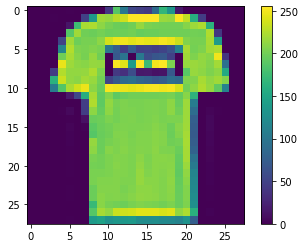

In [8]:
plt.figure()

#show the first image from the training dataset
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Show Sample Data
Show the first 25 images from the training dataset and display the classification name with each.

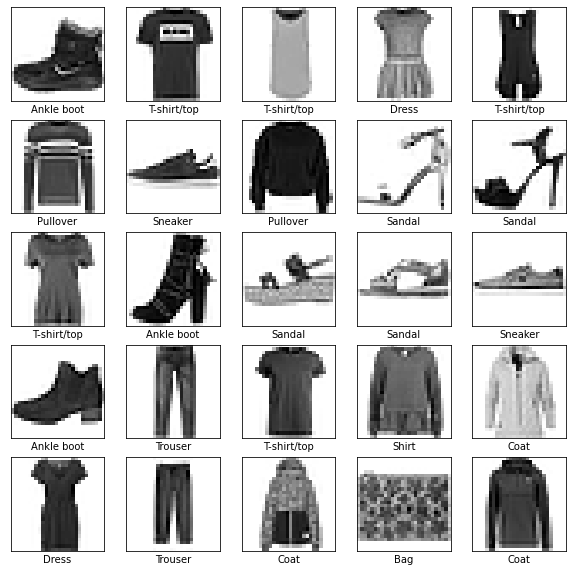

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. 

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

Rectified linear unit (ReLU), is an activation function which means, this is how the neuron determines if it's going to fire (weighting of probabilities). See: https://en.wikipedia.org/wiki/Rectifier_(neural_networks) The short version is that ReLU is considered an excellent tool and using a vanishing gradient to determine probabilities always making sure any value less than zero is set to 0.

In [11]:
#capture the function calls return into a variable, this encapsulate a complex object that defines the entire neural model
model = keras.Sequential([
    #one-D array are preferred for all processing
    #The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array 
    #(of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels 
    #in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
    keras.layers.Flatten(input_shape=(28, 28)),
    
    #first layer is 128 neurons and a ReLU activation function.
    keras.layers.Dense(128, activation='relu'),
    
    #output layer defined
    keras.layers.Dense(10)
])

## Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

    Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

    Optimizer —This is how the model is updated based on the data it sees and its loss function.

    Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [12]:
model.compile(optimizer='adam',
              #v2.1 accepts this activation method but previous versions DO NOT
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Train the model

### Training the neural network model requires the following steps:

    1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
    2. The model learns to associate images and labels.
    3. You ask the model to make predictions about a test set—in this example, the test_images array.
    4. Verify that the predictions match the labels from the test_labels array.

## Feed the model

To start training, call the model.fit method—so called because it "fits" the model to the training data.

What's an "epoch"?

In terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new "unseen" input (test data). An epoch is often mixed up with an iteration. Iterations is the number of batches or steps through partitioned packets of the training data, needed to complete one epoch.  

Since one epoch is too big to feed to the computer at once we divide it in several smaller batches. For this example no batch sizes are defined, defaults are used.  Based on documentation with respect to default batches:

batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, dataset, generators, or keras.utils.Sequence instances (since they generate batches).

In [13]:
#given the images and labels begin learning from the train_* dataset for 10 "iterations".
model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.4954 - accuracy: 0.8256
Epoch 2/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.3715 - accuracy: 0.8661
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3353 - accuracy: 0.8762
Epoch 4/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3135 - accuracy: 0.8851
Epoch 5/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.2930 - accuracy: 0.8924
Epoch 6/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.2799 - accuracy: 0.8978
Epoch 7/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.2669 - accuracy: 0.9018
Epoch 8/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.2570 - accuracy: 0.9043
Epoch 9/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2475 - accuracy: 0.9079
Epoch 10/10
60

Notice each epoc completion demonstrates an accuracy improvement.  You can add a *patience* function to drop out when your training reaches an optimal level to avoid overfitting.

## Evaluate accuracy

Now we see how well the model performs.  The `evaluate()` function performs a prediction by taking the test_* inputs and and performing a diff between actual data and predicted data.

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 1s - loss: 0.3331 - accuracy: 0.8823

Test accuracy: 0.8823


As previously discussed overfitting is a concern.  Notes from the demonstration code:

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

1.  Demonstration of overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting
2.  Strategies to prevent overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting

## Make Predictions

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

### Logits

The vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

In addition, logits sometimes refer to the element-wise inverse of the sigmoid function. For more information, see tf.nn.sigmoid_cross_entropy_with_logits.

In [15]:
#define another model designed to help identify classes
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])


In [16]:
#given the test images what labels have precipitated out?
predictions = probability_model.predict(test_images)

In [17]:
#let's see what the predictions resulting data structure looks like on the inside.
predictions

array([[3.4925961e-08, 1.6158065e-08, 5.3955691e-08, ..., 4.0159808e-03,
        1.1027443e-08, 9.9370366e-01],
       [2.5303420e-05, 4.3557880e-14, 9.9852753e-01, ..., 2.8280964e-21,
        1.1061134e-10, 1.3175297e-17],
       [8.0427942e-10, 1.0000000e+00, 5.6086199e-14, ..., 1.2237545e-22,
        9.8228304e-16, 3.7931882e-21],
       ...,
       [7.3945870e-05, 1.5474195e-09, 1.5228221e-05, ..., 4.2318465e-10,
        9.9957603e-01, 5.4450494e-12],
       [3.2019447e-08, 9.9997079e-01, 7.5427870e-10, ..., 2.3202615e-15,
        4.2772899e-10, 1.2828050e-12],
       [6.8534137e-06, 7.7194440e-10, 2.4042286e-06, ..., 5.1090639e-04,
        9.9166537e-06, 1.7441745e-06]], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [18]:
predictions[0]

array([3.4925961e-08, 1.6158065e-08, 5.3955691e-08, 1.7913280e-11,
       3.0988892e-07, 2.2799082e-03, 2.5057469e-09, 4.0159808e-03,
       1.1027443e-08, 9.9370366e-01], dtype=float32)

In [19]:
#numpy magic, obtain the highest value
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or class_names[9]. Examining the test label shows that this classification is correct:

In [20]:
test_labels[0]

9

In [21]:
print("Label 9 relates to a {}.".format(class_names[np.argmax(predictions[0])]))

Label 9 relates to a Ankle boot.


Graph this to look at the full set of 10 class predictions.

In [22]:
#functions defined to show the item and relevance of the prediction

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

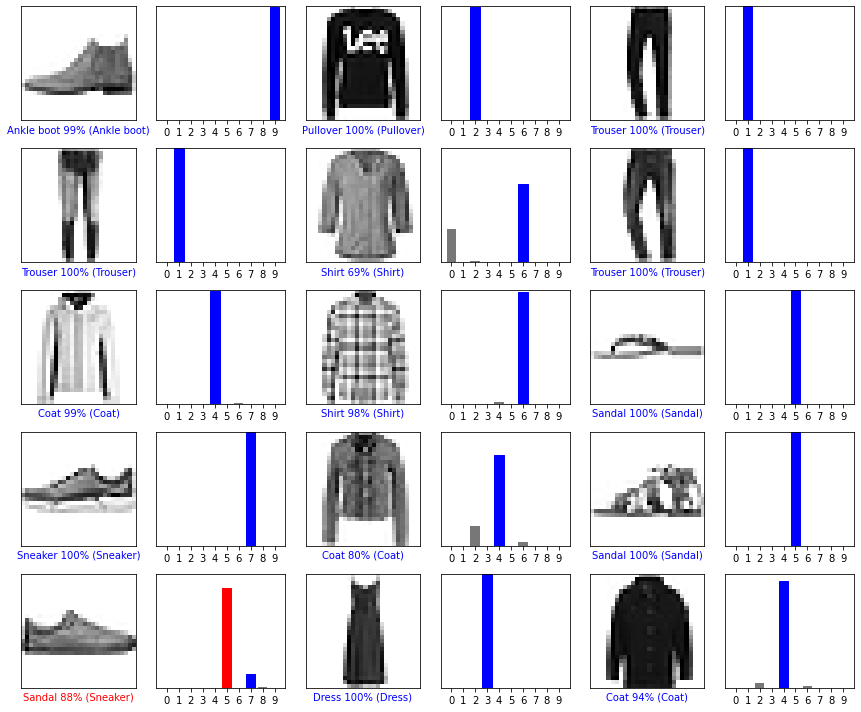

In [23]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


## Use the trained model

Use the trained model to make a prediction about a single image.  We will generate a random number selected out of the domain of values.

### *Note*
tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:


In [24]:
# seed the pseudorandom number generator
from random import seed
from random import random

# seed random number generator
seed(1)

#lowest array position
min=0
#highest array position (note that the returned shape is 1000x28x28)
max=test_images.shape[0]-1

#generate a random value
value = random()

#scale that value to the range we have available
scaled_value = min + (value * (max - min))
scaled_value = int(scaled_value)

In [25]:

#take the an image from the test dataset, normally a 28x28 matrix
img = test_images[scaled_value]

# Add the image to a batch where it's the only member, now a 1x28x28 matrix.
img = (np.expand_dims(img,0))

In [26]:
#predict the correct label for this image
predictions_single = probability_model.predict(img)

print(predictions_single)

[[5.9449078e-05 2.6198936e-06 5.3426290e-01 3.9458382e-06 4.1600820e-01
  3.0020915e-09 4.9648564e-02 7.0354871e-13 1.4296818e-05 2.5017597e-11]]


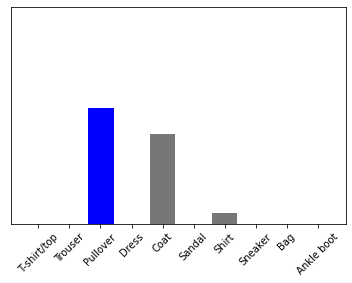

In [27]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [28]:
#keras.Model.predict returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch
np.argmax(predictions_single[0])

2

## Which means ...

In [29]:
print("Prediction is label {} which is a {}.".format(np.argmax(predictions_single[0]),class_names[np.argmax(predictions_single[0])]))
print("Reality suggests label {} which is a {}.".format(test_labels[scaled_value],class_names[test_labels[scaled_value]] ))

Prediction is label 2 which is a Pullover.
Reality suggests label 4 which is a Coat.


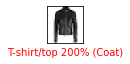

In [30]:
plt.figure(figsize=(1,1))
plot_image(scaled_value,np.argmax(predictions_single[0]), test_labels, test_images)
plt.tight_layout()
plt.show()


[[1.09745685e-07 9.95236098e-12 2.05872584e-06 1.21178512e-09
  5.60668347e-08 9.99983430e-01 8.05888476e-08 1.42380577e-05
  6.78103405e-08 2.40085800e-08]]
Prediction is label 5 which is a Sandal.
Reality suggests label 5 which is a Sandal.


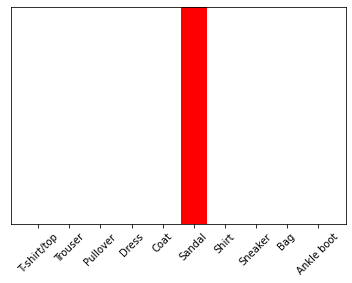

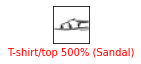

In [31]:
#let's try another one
#generate a random value
value = random()

#scale that value to the range we have available
scaled_value = min + (value * (max - min))
scaled_value = int(scaled_value)
#take the an image from the test dataset, normally a 28x28 matrix
img = test_images[scaled_value]

# Add the image to a batch where it's the only member, now a 1x28x28 matrix.
img = (np.expand_dims(img,0))
#predict the correct label for this image
predictions_single = probability_model.predict(img)

print(predictions_single)
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
np.argmax(predictions_single[0])
print("Prediction is label {} which is a {}.".format(np.argmax(predictions_single[0]),class_names[np.argmax(predictions_single[0])]))
print("Reality suggests label {} which is a {}.".format(test_labels[scaled_value],class_names[test_labels[scaled_value]] ))
plt.figure(figsize=(1,1))
plot_image(scaled_value,np.argmax(predictions_single[0]), test_labels, test_images)
plt.tight_layout()
plt.show()